In [1]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

Read Ground Truth Boxes around human frontal faces

In [2]:
path = "./Raw Data/annotations"
dataset = {"file":[],"xmin":[],"ymin":[],"xmax":[],"ymax":[]}

for anno in glob.glob(path+"/*.xml"):
    tree = ET.parse(anno)
    
    for elem in tree.iter():
        if "object" in elem.tag:
            for attr in list(elem):
                if "name" in attr.tag:
                    name = attr.text
                    dataset["file"] += [anno.split("/")[-1][0:-4]]
                
                if "bndbox" in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin']+=[xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin']+=[ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax']+=[xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax']+=[ymax]                        

# Define 2 dfs
# df on face level, with coordinates of the box
# df_count on image level, with count of faces
df = pd.DataFrame(dataset)
df_count = df.groupby("file").count()

print(df)
print(df_count)

                            file  xmin  ymin  xmax  ymax
0      annotations\maksssksksss0    79   105   109   142
1      annotations\maksssksksss0   185   100   226   144
2      annotations\maksssksksss0   325    90   360   141
3      annotations\maksssksksss1   321    34   354    69
4      annotations\maksssksksss1   224    38   261    73
...                          ...   ...   ...   ...   ...
4067  annotations\maksssksksss98   263    62   287    85
4068  annotations\maksssksksss98   344    80   377   106
4069  annotations\maksssksksss99   181    54   273   162
4070  annotations\maksssksksss99    99    87   176   165
4071  annotations\maksssksksss99   289    99   355   233

[4072 rows x 5 columns]
                             xmin  ymin  xmax  ymax
file                                               
annotations\maksssksksss0       3     3     3     3
annotations\maksssksksss1       9     9     9     9
annotations\maksssksksss10      1     1     1     1
annotations\maksssksksss100    

Helper Functions

In [3]:
def find_face(n):
    """
    This function finds face using haar feature-bases cascade classifiers from input image.
    It returns number of faces, as well as the detailed coordiates of boxes around faces.
    """
    img = cv2.imread(f"./Raw Data/images/maksssksksss{n}.png")
    img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    faces = face_model.detectMultiScale(img,scaleFactor=scale, minNeighbors=4)
            
    return len(faces),faces

def get_iou(bb1, bb2):
    """This function calculates the IOU between two boxes."""
    x_left = max(bb1['xmin'], bb2['xmin'])
    y_top = max(bb1['ymin'], bb2['ymin'])
    x_right = min(bb1['xmax'], bb2['xmax'])
    y_bottom = min(bb1['ymax'], bb2['ymax'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['xmax'] - bb1['xmin']) * (bb1['ymax'] - bb1['ymin'])
    bb2_area = (bb2['xmax'] - bb2['xmin']) * (bb2['ymax'] - bb2['ymin'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    return iou

def precision(n):
    """This function calculates the average precision of a predicted image."""
    faces = find_face(n)[1]
    pred = []
    for (x,y,w,h) in faces:
        dct = {"xmin":x,"ymin":y,"xmax":x+w,"ymax":y+h}
        pred.append(dct)
    
    file = f"annotations\maksssksksss{n}"
    true = df[df["file"]==file][["xmin","ymin","xmax","ymax"]].to_dict(orient="records")

    result = []

    for b1 in pred:
        iou = 0
        for b2 in true:
            iou = max(iou, get_iou(b1,b2))
        result.append(iou)
    
    if not result:
        return "NA"

    return np.mean(result)

def recall(n):
    """This function calculates the recall of a predicted image."""
    pred = find_face(n)[0]
    
    file = f"annotations\maksssksksss{n}"
    true = df_count.loc[file][0]
    
    return pred/true

def evaluate():
    """This function loops through all the data and calculates mean average precision and mean recall."""
    p = []
    r = []

    for i in range(853):
        a = precision(i)
        b = recall(i)
        
        if a != "NA":
            p.append(a)
    
        r.append(b)
    
    return (np.mean(p),np.mean(r))

def show(n):
    """This is a function that could show an individual image with ground truth boxes and predicted boxes."""
    img = cv2.imread(f"./Raw Data/images/maksssksksss{n}.png")
    img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    faces = face_model.detectMultiScale(img,scaleFactor=scale, minNeighbors=4)
    out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
    for (x,y,w,h) in faces:
        cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)

    file = f"annotations\maksssksksss{n}"
    true = df[df["file"]==file][["xmin","ymin","xmax","ymax"]].to_dict(orient="records")

    for face in true:
        cv2.rectangle(out_img,(face["xmin"],face["ymin"]),(face["xmax"],face["ymax"]),(255,0,0),1)

    plt.figure(figsize=(12,12))
    plt.imshow(out_img)

    print((precision(n),recall(n)))

Main

In [6]:
scale = 1.1
face_model = cv2.CascadeClassifier("./Raw Data/haarcascade/haarcascade_frontalface_default.xml")

evaluate()

alt       
0.5736405134185643, 0.2576523557342646

alt2      
0.5706703705891071, 0.2846575854501722

default    
0.4739757997743426, 0.3400260002065463

alt_tree   
0.6081120853631145, 0.04036784499856013

(0.69907100199071, 0.3333333333333333)


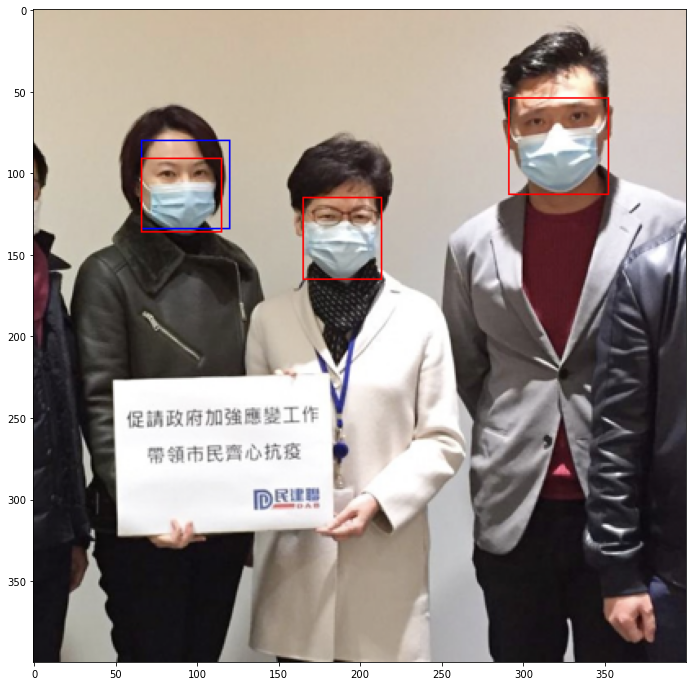

In [17]:
# Show result for individual image
# Blue from model, Red truth
scale = 1.1
face_model = cv2.CascadeClassifier("./Raw Data/haarcascade/haarcascade_frontalface_default.xml")

show(812)